<a href="https://colab.research.google.com/github/franitaa/ADHD-EEG-Game/blob/main/ADHD_EEG_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de ADHD a través de un juego basado en EEG

*   Francesca Rondinella (61031)
*   Nicolás Suárez Durrels (62468)


## Dudas

- Para sujetos non-ADHD, hay data de los canales de EEG y data ya dividida en bandas de frecuencia. Para los sujetos ADHD sólo está la data de las bandas, y por eso nos quedamos solo con esa información en ambos casos para el análisis. Está ok como approach?
- Observando los espectrogramas parecerían tener aún ruido de línea (línea en 50 Hz), o sea que no está 100% procesada la data de las bandas de frecuencia. Estamos decidiendo cuál es la mejor manera de filtrar datos de este tipo, ya que no tenemos las señales crudas.
- Agregamos las columnas que usan en el paper? Nos da dudas, porque son ratios entre las distintas bandas de frecuencia (literalmente, theta/gamma y así). No sabemos si no sería como repetir los datos.
- La frecuencia de muestreo es 125 Hz, según como lo calculamos con los timestamps que están en los datos de no-ADHD. Es correcto pensar que para las bandas de frecuencia, como usan ventanas de tamaño 5 sin overlap, la fs = 125 / 5 = 25 Hz?.



## Imports y carga de datos

In [1]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.8 MB/s eta 0:00:00


In [2]:
#Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from google.colab import drive
import os
import numpy as np
import seaborn as sns
from scipy.signal import spectrogram
from sklearn.manifold import TSNE
from umap import UMAP
import random
import re

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
main_folder_path = '/content/drive/MyDrive/New EEG Data'

# diccionarios
adhd_emotive = {}
adhd_keyboard = {}
non_adhd_emotive = {}
non_adhd_keyboard = {}

def read_and_categorize_csv_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                # categoria segun path
                relative_path = os.path.relpath(file_path, main_folder_path)
                parts = relative_path.split(os.sep)

                if len(parts) >= 3:
                    category = parts[0]  # ADHD o Non-ADHD
                    subcategory = parts[2]  # Emotive o Keyboard

                    #df = pd.read_csv(file_path)
                    df = pd.read_csv(file_path, index_col=False).dropna(how='all')

                    #selected_columns = ['Theta', ' Alpha', ' Low_beta', ' High_beta', ' Gamma ']
                    #filtered_df  = df[selected_columns]
                    # Strip leading/trailing spaces from column names
                    df.columns = df.columns.str.strip()
                    #print("Available columns:", df.columns.tolist())
                    #print(parts)

                    selected_columns = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma']

                    if all(column in df.columns for column in selected_columns):
                      filtered_df  = df[selected_columns]
                      if category == 'ADHD' and subcategory == 'Emotiv':
                          adhd_emotive[relative_path] = df
                      elif category == 'ADHD' and subcategory == 'Keyboard':
                          adhd_keyboard[relative_path] = df
                      elif category == 'Non-ADHD' and subcategory == 'Emotive':
                          non_adhd_emotive[relative_path] = df
                      elif category == 'Non-ADHD' and subcategory == 'Keyboard':
                          non_adhd_keyboard[relative_path] = df



read_and_categorize_csv_files(main_folder_path)

print("ADHD - Emotive:", adhd_emotive.keys())
print("ADHD - Keyboard:", adhd_keyboard.keys())
print("Non-ADHD - Emotive:", non_adhd_emotive.keys())
print("Non-ADHD - Keyboard:", non_adhd_keyboard.keys())


ADHD - Emotive: dict_keys(['ADHD/7/Emotiv/ayse nur emo 1.csv', 'ADHD/7/Emotiv/ayse nur emo 2.csv', 'ADHD/7/Emotiv/ayse nur emo 3.csv', 'ADHD/7/Emotiv/ayse nur emo 4.csv', 'ADHD/7/Emotiv/ayse nur emo 5.csv', 'ADHD/7/Emotiv/ayse nur emo 6.csv', 'ADHD/10/Emotiv/emo zeynep 1.csv', 'ADHD/10/Emotiv/emo zeynep 2.csv', 'ADHD/10/Emotiv/emo zeynep 3.csv', 'ADHD/10/Emotiv/emo zeynep 4.csv', 'ADHD/10/Emotiv/emo zeynep 5.csv', 'ADHD/10/Emotiv/emo zeynep 6.csv', 'ADHD/8/Emotiv/Humam emo 1.csv', 'ADHD/8/Emotiv/Humam emo 2.csv', 'ADHD/8/Emotiv/Humam emo 3.csv', 'ADHD/8/Emotiv/Humam emo 4.csv', 'ADHD/8/Emotiv/Humam emo 5.csv', 'ADHD/8/Emotiv/Humam emo 6.csv', 'ADHD/9/Emotiv/emo said 1.csv', 'ADHD/9/Emotiv/emo said 2.csv', 'ADHD/9/Emotiv/emo said 3.csv', 'ADHD/9/Emotiv/emo said 4.csv', 'ADHD/9/Emotiv/emo said 5.csv', 'ADHD/9/Emotiv/emo said 6.csv'])
ADHD - Keyboard: dict_keys(['ADHD/7/Keyboard/ayse nur key 1.csv', 'ADHD/7/Keyboard/ayse nur key 2.csv', 'ADHD/7/Keyboard/ayse nur key 3.csv', 'ADHD/7/Keyboa

In [5]:
# Combina todos los dataframes
def combine_data(data_dict):
    combined_df = pd.concat(data_dict.values(), ignore_index=True)
    return combined_df


combined_adhd_emotive = combine_data(adhd_emotive)
combined_adhd_keyboard = combine_data(adhd_keyboard)
combined_non_adhd_emotive = combine_data(non_adhd_emotive)
combined_non_adhd_keyboard = combine_data(non_adhd_keyboard)


combined_adhd_emotive['Label'] = 'ADHD_emotive'
combined_adhd_keyboard['Label'] = 'ADHD_keyboard'
combined_non_adhd_emotive['Label'] = 'Non_ADHD_emotive'
combined_non_adhd_keyboard['Label'] = 'Non_ADHD_keyboard'

# Por ahora estamos trabajando solo con emotive
combined_data = pd.concat([combined_adhd_emotive,
                           combined_non_adhd_emotive])

features = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma']
x = combined_data[features]
y = combined_data['Label']

# TODO fijarse si hay mejor forma de sacar outliers
z_scores = np.abs((x - x.mean()) / x.std())
x = x[(z_scores < 3).all(axis=1)]
y = y[(z_scores < 3).all(axis=1)]
# Estandarizamos
x = StandardScaler().fit_transform(x)
print(y)

0             ADHD_emotive
1             ADHD_emotive
2             ADHD_emotive
3             ADHD_emotive
4             ADHD_emotive
                ...       
103660    Non_ADHD_emotive
103661    Non_ADHD_emotive
103662    Non_ADHD_emotive
103663    Non_ADHD_emotive
103664    Non_ADHD_emotive
Name: Label, Length: 186343, dtype: object


In [6]:
# Combino num_samples de adhd y non adhd. Termino con num_samples*2 totales
# También marco en y_subset non adhd y a los adhd los diferencio por paciente
num_samples = 35000


adhd_df_list = []
for key, df in adhd_emotive.items():
    adhd_number = re.search(r'ADHD/(\d+)/', key).group(1)

    df['Label'] = f"ADHD_{adhd_number}"
    adhd_df_list.append(df)
combined_adhd_emotive = pd.concat(adhd_df_list, ignore_index=True)


non_adhd_df_list = []
for key, df in non_adhd_emotive.items():
    df['Label'] = 'Non_ADHD'
    non_adhd_df_list.append(df)
combined_non_adhd_emotive = pd.concat(non_adhd_df_list, ignore_index=True)

# features
features = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma']

# Estandarizar
scaler = StandardScaler()
x_adhd = scaler.fit_transform(combined_adhd_emotive[features])
x_non_adhd = scaler.fit_transform(combined_non_adhd_emotive[features])

# Labels
y_adhd = combined_adhd_emotive['Label']
y_non_adhd = combined_non_adhd_emotive['Label']

# TODO: agarrar la misma cantidad de cada uno de los adhd. Ahora mismo agarra random, pero como tienen diferente tamaño
# Terminamos analizando diferentes proporciones de los adhd
random.seed(42)
adhd_indices = random.sample(range(len(x_adhd)), num_samples)
non_adhd_indices = random.sample(range(len(x_non_adhd)), num_samples)

x_subset = np.concatenate((x_adhd[adhd_indices], x_non_adhd[non_adhd_indices]), axis=0)
y_subset = pd.concat([y_adhd.iloc[adhd_indices].reset_index(drop=True),
                      y_non_adhd.iloc[non_adhd_indices].reset_index(drop=True)])
print(y_subset.value_counts())



Label
Non_ADHD    35000
ADHD_7      13003
ADHD_10      9526
ADHD_8       9109
ADHD_9       3362
Name: count, dtype: int64


## Análisis preliminar de los datos

En esta sección, como el dataset ya ha sido pre-procesado y dividido en bandas de frecuencia se realizan técnicas de reducción de dimensionalidad para sacar conclusiones acerca de las componentes más relevantes del problema.

Queda aún la duda de si es necesario aplicar filtros adicionales a los datos, y si es así, como hacerlo (dado que se trata de datos segmentados por banda de frecuencia).

### Espectrogramas

In [7]:
values = non_adhd_emotive['Non-ADHD/2/Emotive/alaa_emo1.csv']

In [8]:
values2 = adhd_emotive['ADHD/10/Emotiv/emo zeynep 5.csv']

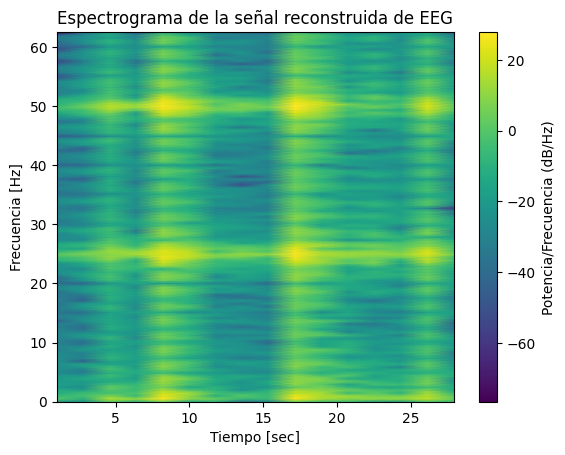

In [9]:
full_signal1 = values['Alpha'] + values['Theta'] + values['High_beta'] + values['Low_beta'] + values['Gamma']

fs = 125

f, t, Sxx = spectrogram(full_signal1, fs)

plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [sec]')
plt.title('Espectrograma de la señal reconstruida de EEG')
plt.colorbar(label='Potencia/Frecuencia (dB/Hz)')
plt.show()

Comentarios: se nota la banda característica de ruido de línea en todo el espectro a 50 Hz, que pareciera no estar filtrada por el color (potencia positiva). Sin embargo, tiene otras líneas que no sé a que atribuir (alrededor de 25 Hz y las otras verticales). Podría deberse a gaps según como hayan tomado las bandas frecuenciales.

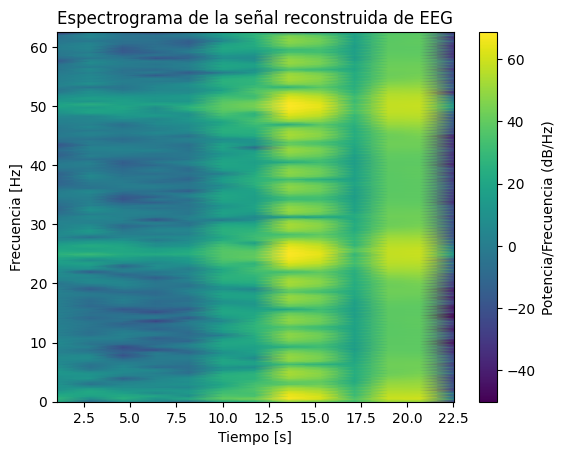

In [10]:
full_signal2 = values2['Alpha'] + values2['Theta'] + values2['High_beta'] + values2['Low_beta'] + values2['Gamma']

fs = 125

f, t, Sxx = spectrogram(full_signal2, fs)

plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title('Espectrograma de la señal reconstruida de EEG')
plt.colorbar(label='Potencia/Frecuencia (dB/Hz)')
plt.show()

Punto positivo: se ven distintos. Tiene sentido hacer espectrogramas así y después hacer PCA o LDA a ver que sale?

Citando el comentario de Facu: "Imagino que un PCA aplicado a los espectrogramas de las señales podría llegar a darles información acerca de la composición". La idea sería ver que bandas de frecuencia explican la mayor varianza? No entendemos bien como se aplica PCA al espectrograma.

Otras features que podemos usar, que son usuales en análisis de EEG, son: dimensión fractal, ICA, FFT, Wavelet Transform.

En próxima sección ploteamos dos señales a modo de ejemplo, de cada clase de sujeto. Se ven diferencias sustanciales en la amplitud, especialmente de los ritmos theta.

In [11]:
print(len(full_signal1))
print(len(full_signal2))

3740
3120


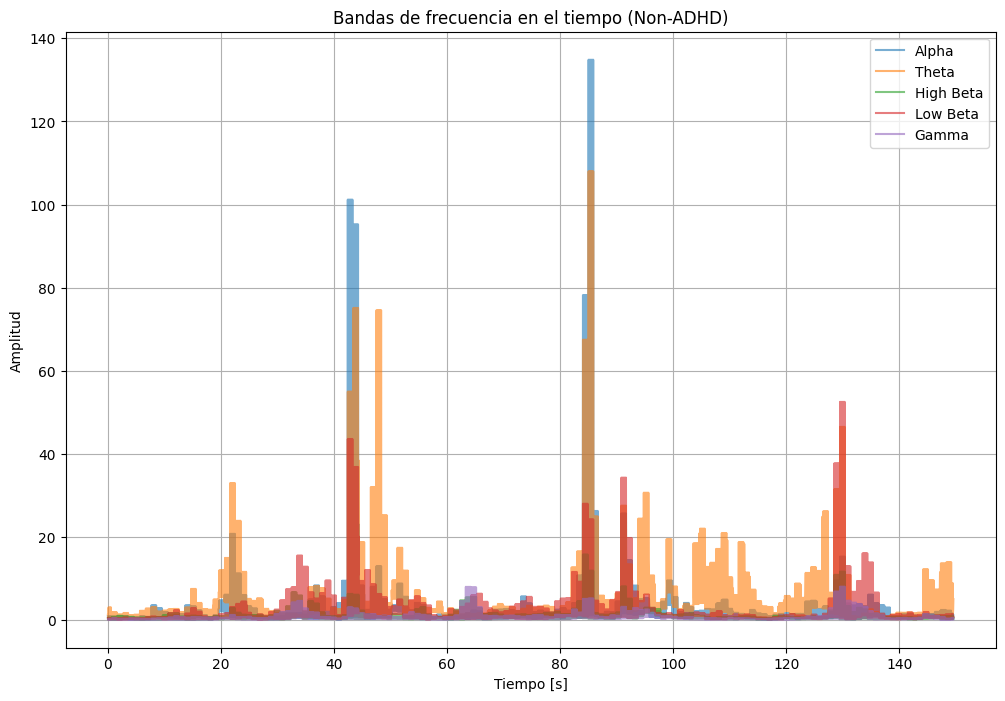

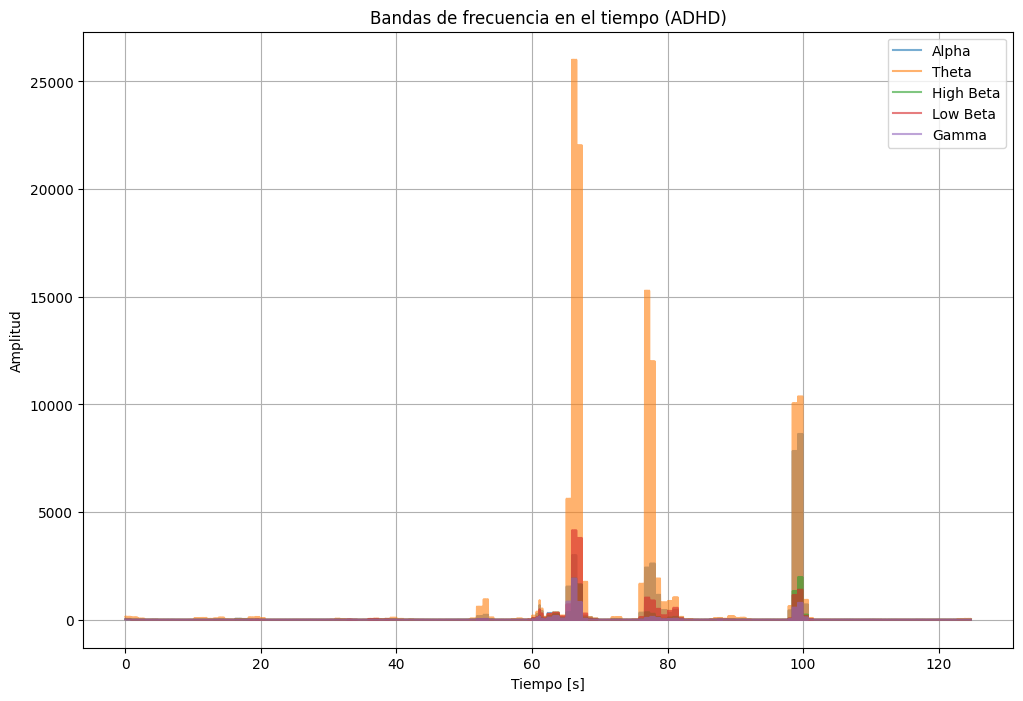

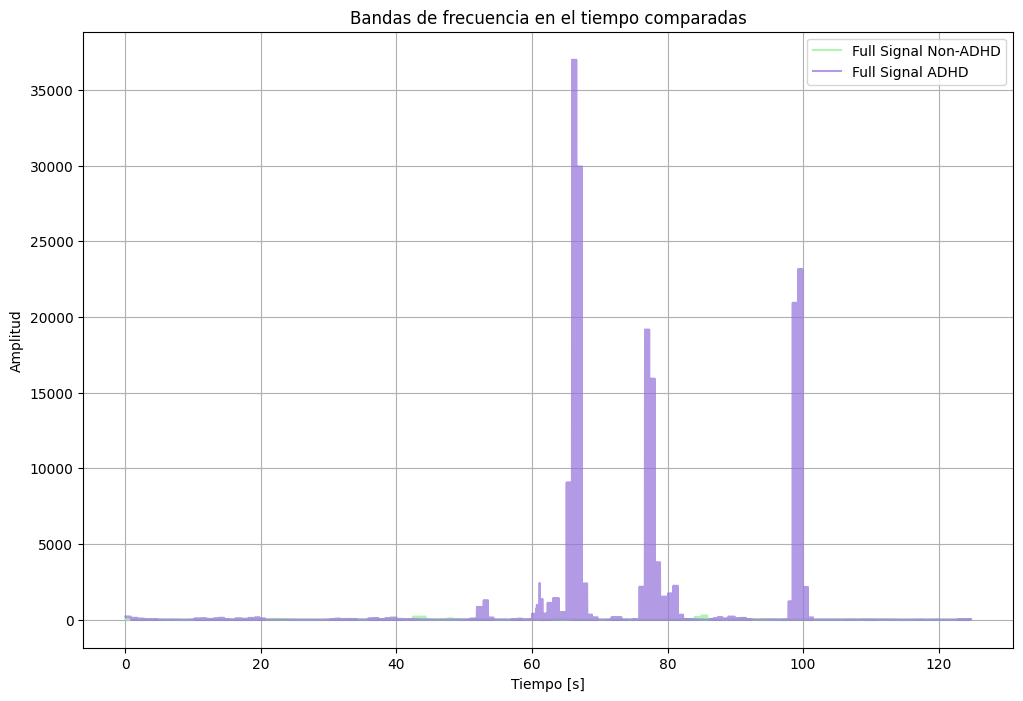

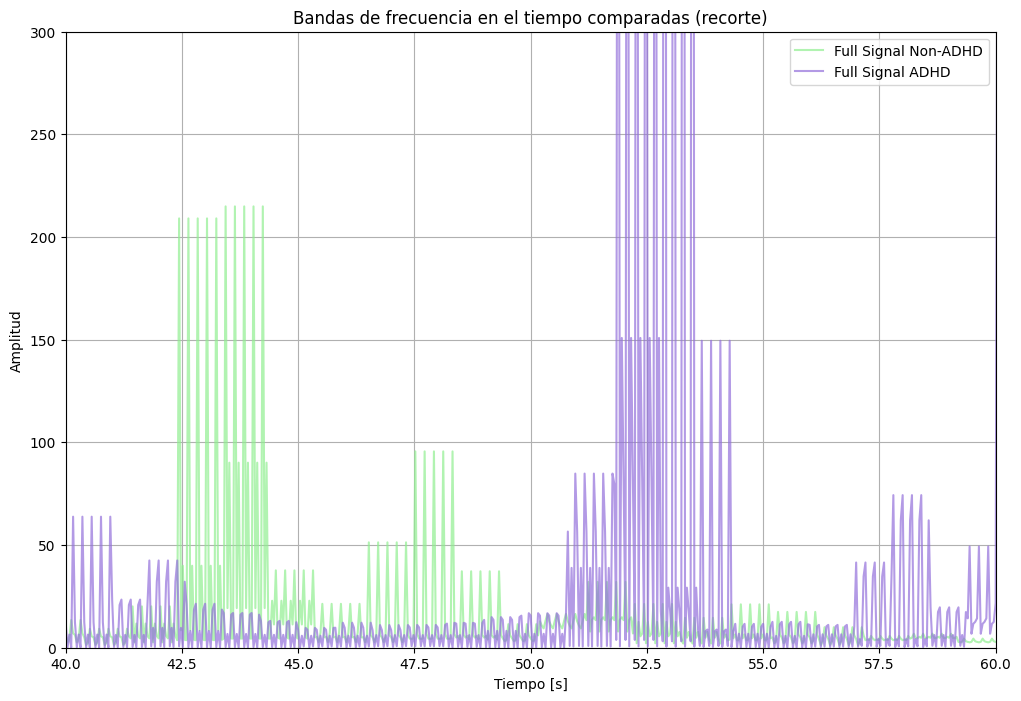

In [14]:
# @title Ploteo
alpha = values['Alpha']
theta = values['Theta']
high_beta = values['High_beta']
low_beta = values['Low_beta']
gamma = values['Gamma']


fs = 125/5  # no sé si esto está bien, es fs/window size
t = values.index / fs

plt.figure(figsize=(12, 8))

plt.plot(t, alpha, label='Alpha', alpha=0.6)
plt.plot(t, theta, label='Theta', alpha=0.6)
plt.plot(t, high_beta, label='High Beta', alpha=0.6)
plt.plot(t, low_beta, label='Low Beta', alpha=0.6)
plt.plot(t, gamma, label='Gamma', alpha=0.6)

# plt.plot(t, full_signal, label='Full Signal', linestyle='--', color='black', alpha=0.7)

plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Bandas de frecuencia en el tiempo (Non-ADHD)')
plt.legend()
plt.grid(True)

plt.show()

alpha2 = values2['Alpha']
theta2 = values2['Theta']
high_beta2 = values2['High_beta']
low_beta2 = values2['Low_beta']
gamma2 = values2['Gamma']

t = values2.index / fs


plt.figure(figsize=(12, 8))

plt.plot(t, alpha2, label='Alpha', alpha=0.6)
plt.plot(t, theta2, label='Theta', alpha=0.6)
plt.plot(t, high_beta2, label='High Beta', alpha=0.6)
plt.plot(t, low_beta2, label='Low Beta', alpha=0.6)
plt.plot(t, gamma2, label='Gamma', alpha=0.6)

# plt.plot(t, full_signal, label='Full Signal', linestyle='--', color='black', alpha=0.7)

plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Bandas de frecuencia en el tiempo (ADHD)')
plt.legend()
plt.grid(True)

plt.show()


plt.figure(figsize=(12, 8))

plt.plot(t, full_signal1[:len(full_signal2)], label='Full Signal Non-ADHD', color='lightgreen', alpha=0.7)
plt.plot(t, full_signal2, label='Full Signal ADHD', color='mediumpurple', alpha=0.7)


plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Bandas de frecuencia en el tiempo comparadas')
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize=(12, 8))

plt.plot(t, full_signal1[:len(full_signal2)], label='Full Signal Non-ADHD', color='lightgreen', alpha=0.7)
plt.plot(t, full_signal2, label='Full Signal ADHD', color='mediumpurple', alpha=0.7)


plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.xlim((40,60))
plt.ylim((0,300))
plt.title('Bandas de frecuencia en el tiempo comparadas (recorte)')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
print(non_adhd_emotive['Non-ADHD/2/Emotive/alaa_emo1.csv'].keys)

<bound method NDFrame.keys of          Theta     Alpha  Low_beta  High_beta     Gamma
0     1.240181  0.900676  0.409132   0.431120  0.082212
1     0.398977  0.348877  0.132882   0.096119  0.079564
2     0.728530  0.687372  0.148767   0.161910  0.234107
3     3.042919  0.753375  0.542238   0.557061  0.284002
4     1.046734  0.853509  0.409447   0.401535  0.109164
...        ...       ...       ...        ...       ...
3735  4.077168  0.359713  0.971347   0.492080  0.140560
3736  8.874057  1.564990  1.426825   1.073386  0.477012
3737  1.536944  0.245191  0.320641   0.314630  0.240329
3738  2.515144  1.364814  0.950630   0.750367  0.422408
3739  5.025025  0.391393  0.701822   0.373607  0.127021

[3740 rows x 5 columns]>


### PCA

Principal components (eigenvectors):
[[ 0.43269624  0.46423371  0.47454453  0.47295762  0.38520073]
 [ 0.47625895  0.36964866  0.09560642 -0.29614728 -0.73463833]]

Explained variance ratio:
[0.75636126 0.13843159]


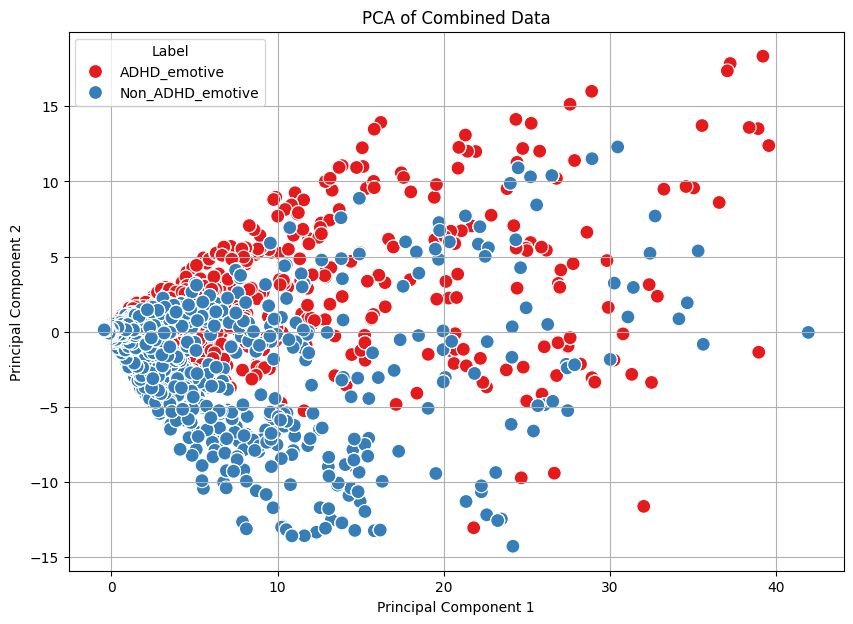

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])

# Asocio los labels
final_df = pd.concat([principal_df, y.reset_index(drop=True)], axis=1)

print("Principal components (eigenvectors):")
print(pca.components_)

print("\nExplained variance ratio:")
print(pca.explained_variance_ratio_)


plt.figure(figsize=(10, 7))
sns.scatterplot(data=final_df, x='principal_component_1', y='principal_component_2', hue='Label', palette='Set1', s=100)
plt.title('PCA of Combined Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

### LDA

Por lo que entendemos, LDA puede graficar en una dimensión en nuestro caso. Toma el mínimo entre las features (5) y la cantidad de clases - 1 (si tomamos solo ADHD vs non-ADHD, es 1). Si hago este grafico con histograma no llego a nada lindo, porque los dos grupos concentran sus datos en casi el mismo lugar.

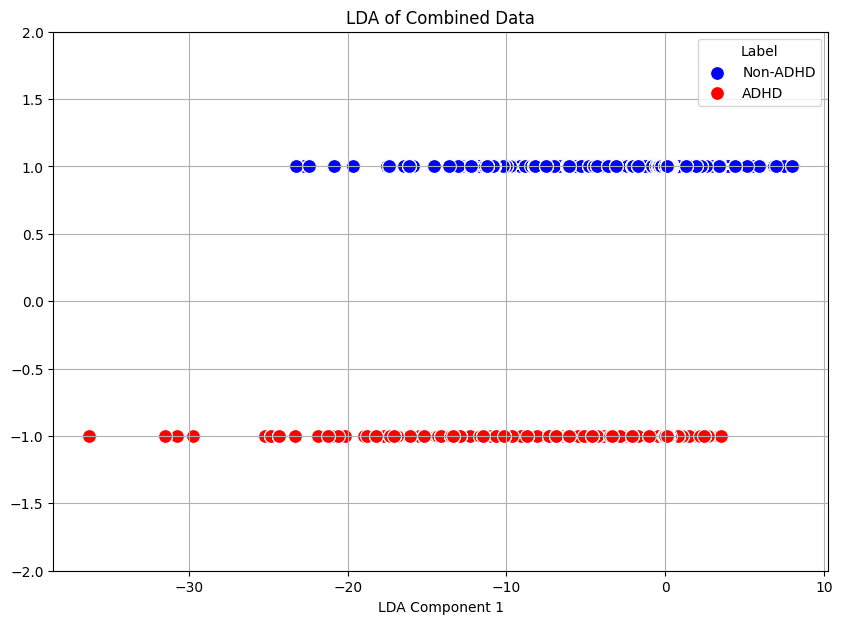

LDA coefficients:
[[-0.15049549  0.0452969   0.0857798  -0.20740394  0.09700832]]

Explained variance ratio:
[1.]


In [ ]:
lda = LDA(n_components=1)

lda_components = lda.fit_transform(x, y)

lda_df = pd.DataFrame(data=lda_components, columns=['lda_component_1'])

final_df = pd.concat([lda_df, y.reset_index(drop=True)], axis=1)

# Separo en base a label
non_adhd_data = final_df[final_df['Label'] == 'Non_ADHD_emotive']
adhd_data = final_df[final_df['Label'] == 'ADHD_emotive']

plt.figure(figsize=(10, 7))

sns.scatterplot(data=non_adhd_data, x='lda_component_1', y=np.ones(len(non_adhd_data)), color='blue', label='Non-ADHD', s=100)

sns.scatterplot(data=adhd_data, x='lda_component_1', y=-np.ones(len(adhd_data)), color='red', label='ADHD', s=100)

plt.title('LDA of Combined Data')
plt.xlabel('LDA Component 1')
plt.ylabel('')
plt.ylim(-2, 2)  # Hay outliers lejanos
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

print("LDA coefficients:")
print(lda.coef_)

explained_variance_ratio = lda.explained_variance_ratio_
print("\nExplained variance ratio:")
print(explained_variance_ratio)

### t-SNE

Por ahora estamos trabajando con subsets, ya que al trabajar con toda la data tarda demasiado. De todas formas, podemos ver que los datos se agrupan de acuerdo a ADHD y sin ADHD. Utilizando diferentes colores para los datos de cada sujeto con ADHD, también se puede observar que estos se agrupan según la persona. Los datos del sujeto 7 son los mas cercanos a los datos sin ADHD.


La idea de colorear los distintos sujetos de ADHD nace a partir de la voluntad de diferenciar a la persona que recibió tratamiento. En el paper se la nombra como P2 y sospechamos que se trata del sujeto 8, pero no estamos seguros ya que no se explicita en cuanto al dataset. Queremos comunicarnos con los investigadores para saber si nos lo pueden decir.

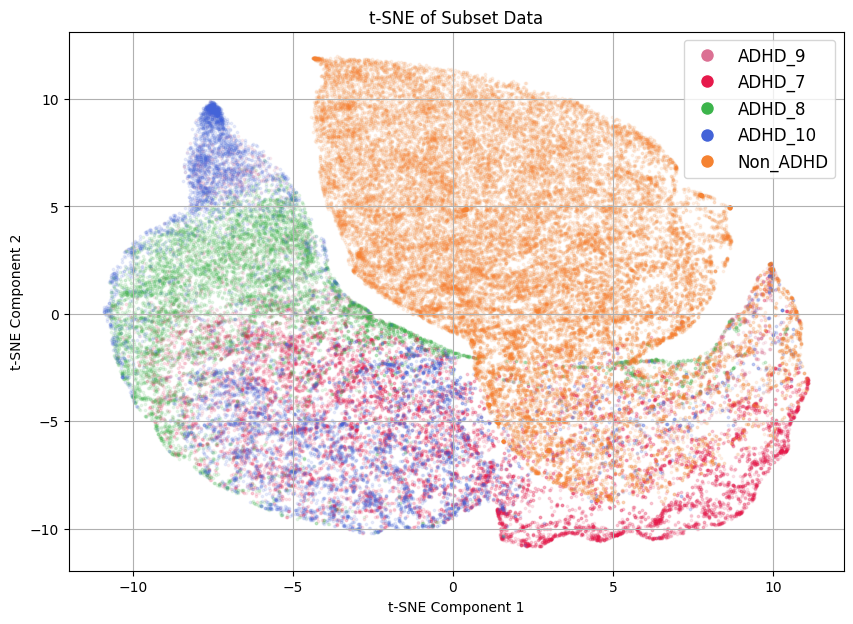

In [ ]:

tsne_model = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate=200,
    n_iter=350
)


tsne_components = tsne_model.fit_transform(x_subset)

tsne_df = pd.DataFrame(data=tsne_components, columns=['tsne_component_1', 'tsne_component_2'])

y_concatenated = pd.concat([y[:subset_size_each].reset_index(drop=True), y[-subset_size_each:].reset_index(drop=True)])
final_df_tsne = pd.concat([tsne_df, y_subset.reset_index(drop=True)], axis=1)

color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_tsne['Label'].unique():
    subset = final_df_tsne[final_df_tsne['Label'] == label]
    plt.scatter(
        subset['tsne_component_1'],
        subset['tsne_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('t-SNE of Subset Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)
plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
tsne_model = TSNE(
    n_components=2,
    perplexity=250,
    learning_rate=200,
    n_iter=550
)


tsne_components = tsne_model.fit_transform(x_subset)

tsne_df = pd.DataFrame(data=tsne_components, columns=['tsne_component_1', 'tsne_component_2'])

final_df_tsne = pd.concat([tsne_df, y_subset.reset_index(drop=True)], axis=1)

color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_tsne['Label'].unique():
    subset = final_df_tsne[final_df_tsne['Label'] == label]
    plt.scatter(
        subset['tsne_component_1'],
        subset['tsne_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('t-SNE of Subset Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)
plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()

### UMAP

Similarmente a t-SNE podemos ver que llegamos a un resultado prometedor. Por un lado tenemos a la mayoria de los puntos sin ADHD, mientras que en el otro lado tenemos a la mayoria de los puntos con ADHD. TODO check si es correcto agregarle ruido, ya que me lo pide al utilizar verbose.

<bound method DataFrame.info of        umap_component_1  umap_component_2
0              6.941781         14.199130
1              7.051848          9.136665
2             10.470878          9.973435
3              8.841610         10.658135
4              0.789802          7.921194
...                 ...               ...
69995         12.663960          2.633303
69996         10.523225          3.200865
69997         12.139360         -5.328474
69998          8.419874         14.071481
69999         13.168877          1.822857

[70000 rows x 2 columns]>
<bound method DataFrame.info of        umap_component_1  umap_component_2     Label
0              6.941781         14.199130    ADHD_9
1              7.051848          9.136665    ADHD_7
2             10.470878          9.973435    ADHD_7
3              8.841610         10.658135    ADHD_8
4              0.789802          7.921194    ADHD_8
...                 ...               ...       ...
69995         12.663960          2.633303

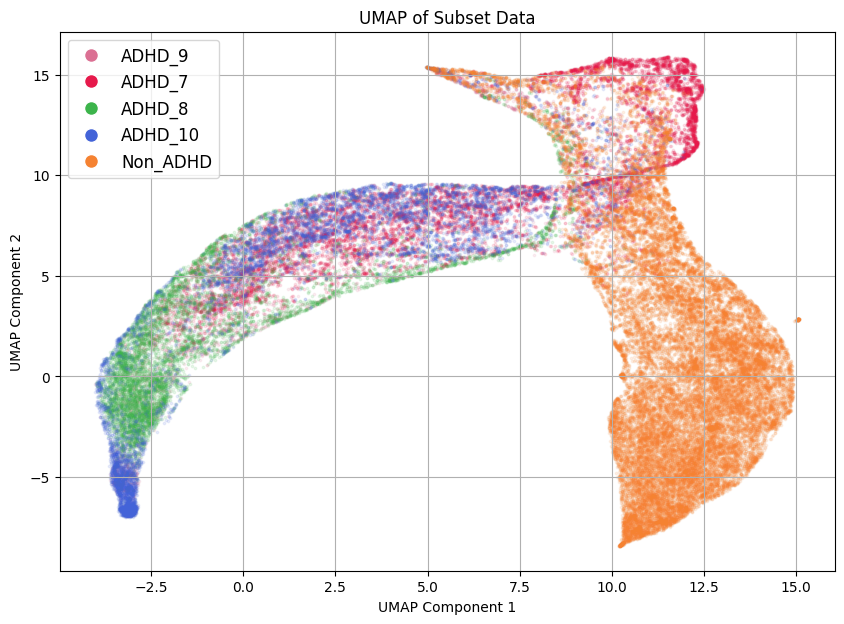

In [ ]:

noise = np.random.normal(0, 0.0001, size=x_subset.shape)
x_subset = x_subset + noise

umap_model = UMAP(
    n_components=2,
    n_neighbors=150,
    min_dist=0.2,
    metric='euclidean',
    learning_rate=0.5,
    n_epochs=300,
    n_jobs=-1,
    verbose=False
)

umap_components = umap_model.fit_transform(x_subset)

umap_df = pd.DataFrame(data=umap_components, columns=['umap_component_1', 'umap_component_2'])
print(umap_df.info)

final_df_umap = pd.concat([umap_df, y_subset.reset_index(drop=True)], axis=1)

print(final_df_umap.info)

color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_umap['Label'].unique():
    subset = final_df_umap[final_df_umap['Label'] == label]
    plt.scatter(
        subset['umap_component_1'],
        subset['umap_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('UMAP of Subset Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)

plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()

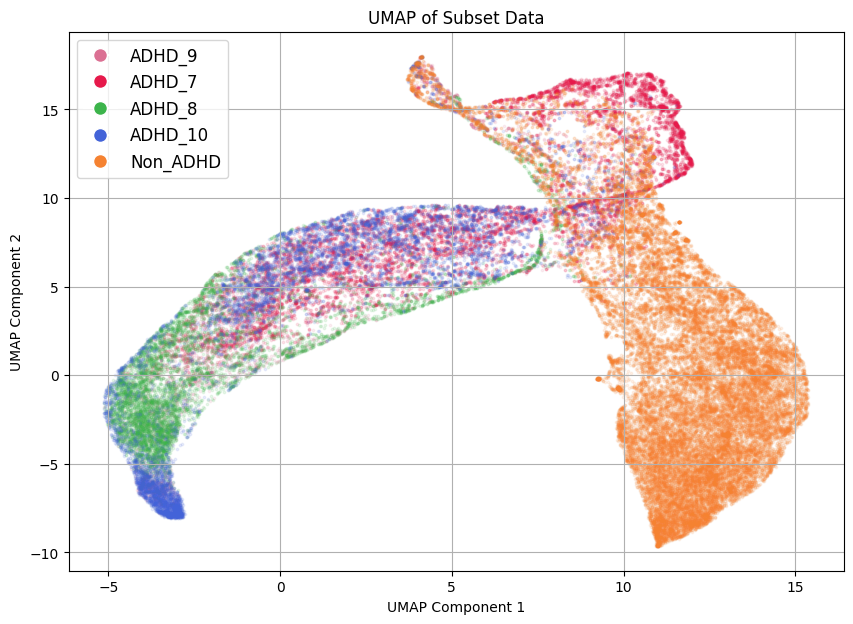

In [ ]:
noise = np.random.normal(0, 0.0001, size=x_subset.shape)
x_subset = x_subset + noise

umap_model = UMAP(
    n_components=2,
    n_neighbors=50,
    min_dist=0.2,
    metric='euclidean',
    learning_rate=0.5,
    n_epochs=300,
    n_jobs=-1,
    verbose=False
)

umap_components = umap_model.fit_transform(x_subset)

umap_df = pd.DataFrame(data=umap_components, columns=['umap_component_1', 'umap_component_2'])

final_df_umap = pd.concat([umap_df, y_subset.reset_index(drop=True)], axis=1)


color_palette = {
    'ADHD_7': '#e6194b',  # Red
    'ADHD_8': '#3cb44b',  # Green
    'ADHD_9': '#db7093',  # Pink
    'ADHD_10': '#4363d8',  # Blue
    'Non_ADHD': '#f58231'  # Orange
}

plt.figure(figsize=(10, 7))
for label in final_df_umap['Label'].unique():
    subset = final_df_umap[final_df_umap['Label'] == label]
    plt.scatter(
        subset['umap_component_1'],
        subset['umap_component_2'],
        label=label,
        c=color_palette[label],
        s=3,
        alpha=0.1
    )
plt.title('UMAP of Subset Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                            markerfacecolor=handle.get_facecolor()[0], markersize=10, alpha=1.0)

plt.legend(handles=handles, loc='best', fontsize=12)
plt.grid(True)
plt.show()